In [107]:
import os
from time import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import make_scorer, f1_score

import scipy.stats as stats
from scipy.stats import uniform


In [3]:
clinical_attributes = pd.read_csv('step_04/clinical_attributes.csv')
z_score = pd.read_csv('step_04/z_score.csv')
mutation = pd.read_csv('step_04/mutation.csv')
response = pd.read_csv('step_04/response.csv')

In [4]:
y = response['overall_survival'].to_numpy()
datasets = [
    ("clinical", clinical_attributes.to_numpy()),
    ("z_score", z_score.to_numpy()),
    ("mutation", mutation.to_numpy())
]

# GridSearch vs HalvingGridSearch vs Random

In [105]:
class Models():
    def __init__(self, linspace_size: int = 3, n_iter_search: int = 15):
        self.linspace_size = 3
        self.algorithms = {
                "knn": ( 
                    KNeighborsClassifier(),
                    {
                        "n_neighbors": np.linspace(3, 10, num=linspace_size, dtype=int),
                        "weights": ["uniform", "distance"],
                        "p": np.linspace(1, 10, num=3, dtype=int),
                        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                        "leaf_size": np.linspace(10, 100, num=linspace_size, dtype=int),
                        "metric": ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
                    }
                ),
                "dt": (
                    DecisionTreeClassifier(),
                    {
                        "criterion": ["gini", "entropy", "log_loss"],
                        "splitter": ["best", "random"],
                        "max_depth": np.linspace(1, 100, num=linspace_size, dtype=int),
                        "min_samples_split": np.linspace(2, 100, num=linspace_size, dtype=int),
                        "min_samples_leaf": np.linspace(1, 100, num=linspace_size, dtype=int),
                        "max_features": ["sqrt", "log2"],
                        "ccp_alpha": np.linspace(0, 0.1, num=3),
                    }
                ),
                "svm": (
                    SVC(),
                    {
                        "C": np.linspace(0.1, 10, num=linspace_size),
                        "kernel": ["linear", "poly", "rbf", "sigmoid"],
                        "degree": np.linspace(1, 10, num=linspace_size, dtype=int),
                        "gamma": ["scale", "auto"],
                        "coef0": np.linspace(0, 10, num=linspace_size),
                        "shrinking": [True, False],
                        "probability": [True, False],
                        "tol": np.linspace(0.0001, 0.01, num=linspace_size),
                    }
                ),
                "rf": (
                    RandomForestClassifier(),
                    {
                        "n_estimators": np.linspace(100, 200, num=linspace_size, dtype=int), # 30 segundos
                        "criterion": ["gini", "entropy", "log_loss"],
                        "max_depth": np.linspace(1, 100, num=linspace_size, dtype=int),
                        #"min_samples_split": np.linspace(2, 10, num=linspace_size, dtype=int), 20 segundos
                        #"min_samples_leaf": np.linspace(1, 10, num=linspace_size, dtype=int),
                        #"max_leaf_nodes": np.linspace(10, 90, num=9, dtype=int), # 1 minuto y algo, Afecta demasiado al tiempo
                        #"min_impurity_decrease": np.linspace(0, 0.1, num=linspace_size),
                        "max_features": ["sqrt", "log2"],
                        "ccp_alpha": np.linspace(0, 0.1, num=linspace_size),
                        "class_weight": ["balanced", "balanced_subsample"]
                    }
                ),
                "ada": (
                    AdaBoostClassifier(),
                    {
                        "n_estimators": np.linspace(10, 100, num=linspace_size, dtype=int),
                        "learning_rate": np.linspace(0.1, 1, num=linspace_size),
                        "algorithm": ["SAMME", "SAMME.R"],
                    }
                )    
        }
        self.n_iter_search = n_iter_search

    def report(self, results, n_top: int = 3):
        export_list = []
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results["rank_test_score"] == i)
            for candidate in candidates:
                export_list.append({
                    "rank": i,
                    "mean_test_score": results["mean_test_score"][candidate],
                    "std_test_score": results["std_test_score"][candidate],
                    "params": results["params"][candidate]
                })
        
        return pd.DataFrame(export_list, columns=["rank", "mean_test_score", "std_test_score", "params"])

    def random_search(self, algorithm: str, seed: int = 42):
        return RandomizedSearchCV(self.algorithms[algorithm][0], self.algorithms[algorithm][1], n_iter=self.n_iter_search, random_state=seed, n_jobs=-1)
    
    def grid_search(self, algorithm: str):
        return GridSearchCV(self.algorithms[algorithm][0], self.algorithms[algorithm][1], n_jobs=-1)
    
    def halving_search(self, algorithm: str):
        return HalvingGridSearchCV(self.algorithms[algorithm][0], self.algorithms[algorithm][1], n_jobs=-1)
    
    def halving_search_f1(self, algorithm: str):
        scoring = make_scorer(f1_score, average='macro')
        return HalvingGridSearchCV(
            clf=self.algorithms[algorithm][0], 
            param_grid=self.algorithms[algorithm][1], 
            n_jobs=-1, 
            scoring=scoring
            )

    
    def compare_search(self, dataset: str, X: np.array, y: np.array, algorithm: str, seed: int = 42):
        export_list = []
        
        print(f"Running Grid Search with {dataset} and {algorithm}...")
        grid_search = self.grid_search(algorithm)
        
        start = time()
        grid_search.fit(X, y)
        time_spent = time() - start

        print("Grid Search took %.2f seconds" % (time_spent))

        results = grid_search.cv_results_

        candidate = np.flatnonzero(results["rank_test_score"] == 1)[0]
        
        export_list.append({
            "dataset": dataset,
            "type": "grid",
            "time": time_spent,
            "algorithm": algorithm,
            "mean_test_score": results["mean_test_score"][candidate],
            "std_test_score": results["std_test_score"][candidate],
            "params": results["params"][candidate]
        })

        print("Running Random Search...")
        random_search = self.random_search(algorithm, seed)

        start = time()
        random_search.fit(X, y)
        time_spent = time() - start

        print("Random Search took %.2f seconds" % (time_spent))

        results = random_search.cv_results_

        candidate = np.flatnonzero(results["rank_test_score"] == 1)[0]

        export_list.append({
            "dataset": dataset,
            "type": "random",
            "time": time_spent,
            "algorithm": algorithm,
            "mean_test_score": results["mean_test_score"][candidate],
            "std_test_score": results["std_test_score"][candidate],
            "params": results["params"][candidate]
        })

        print("Running Halving Grid Search...")
        halving_search = self.halving_search(algorithm)

        start = time()
        halving_search.fit(X, y)
        time_spent = time() - start

        print("Halving Grid Search took %.2f seconds" % (time_spent))

        results = halving_search.cv_results_
        
        candidate = np.flatnonzero(results["rank_test_score"] == 1)[0]

        export_list.append({
            "dataset": dataset,
            "type": "halving",
            "time": time_spent,
            "algorithm": algorithm,
            "mean_test_score": results["mean_test_score"][candidate],
            "std_test_score": results["std_test_score"][candidate],
            "params": results["params"][candidate]
        })

        return pd.DataFrame(export_list, columns=["dataset", "type", "time", "algorithm", "mean_test_score", "std_test_score", "params"])

In [6]:
models_instance = Models(linspace_size=5, n_iter_search=10)
df = pd.DataFrame(columns=["dataset", "type", "time", "mean_test_score", "std_test_score", "params"])
for algorithm in models_instance.algorithms.keys():
    for name, data in datasets:

        try:
            tmp = models_instance.compare_search(name, data, np.squeeze(y), algorithm)
        except:
            print(f"Something happened in {algorithm} - {name}, skipping...")
            continue

        df = pd.concat([df, tmp])

df.to_csv("step_07/compare_search.csv", index=False)
df


Running Grid Search with clinical and rf...


KeyboardInterrupt: 

### Some tests

In [8]:
compare_search = pd.read_csv('step_07/compare_search.csv')
compare_search

,dataset,type,time,algorithm,mean_test_score,std_test_score,params
0,clinical,grid,36.868576,knn,0.638715,0.024175,"{'algorithm': 'auto', 'leaf_size': np.int64(10..."
1,clinical,random,0.354413,knn,0.633616,0.033838,"{'weights': 'uniform', 'p': np.int64(5), 'n_ne..."
2,clinical,halving,5.335104,knn,0.608827,0.040188,"{'algorithm': 'brute', 'leaf_size': np.int64(1..."
3,z_score,grid,399.067785,knn,0.557534,0.036085,"{'algorithm': 'auto', 'leaf_size': np.int64(10..."
4,z_score,random,2.425099,knn,0.539780,0.020754,"{'weights': 'uniform', 'p': np.int64(5), 'n_ne..."
5,z_score,halving,98.605742,knn,0.565152,0.134976,"{'algorithm': 'auto', 'leaf_size': np.int64(10..."
6,mutation,grid,296.353227,knn,0.516098,0.027559,"{'algorithm': 'kd_tree', 'leaf_size': np.int64..."
7,mutation,random,1.624067,knn,0.509247,0.030589,"{'weights': 'uniform', 'p': np.int64(1), 'n_ne..."
8,mutation,halving,13.662691,knn,0.583333,0.149071,"{'algorithm': 'auto', 'leaf_size': np.int64(10..."
9,clinical,grid,4.215403,dt,0.638676,0.045179,"{'ccp_alpha': np.float64(0.0), 'criterion': 'e..."


In [13]:
compare_search.sort_values(by="time", ascending=False).head(6)

,dataset,type,time,algorithm,mean_test_score,std_test_score,params
24,mutation,grid,86806.290341,svm,0.539698,0.037195,"{'C': np.float64(10.0), 'coef0': np.float64(0...."
21,z_score,grid,11565.559470,svm,0.604863,0.083602,"{'C': np.float64(2.575), 'coef0': np.float64(2..."
18,clinical,grid,5023.989629,svm,0.642090,0.032930,"{'C': np.float64(0.1), 'coef0': np.float64(0.0..."
30,z_score,grid,809.097222,rf,0.597222,0.090132,"{'ccp_alpha': np.float64(0.0), 'class_weight':..."
3,z_score,grid,399.067785,knn,0.557534,0.036085,"{'algorithm': 'auto', 'leaf_size': np.int64(10..."
6,mutation,grid,296.353227,knn,0.516098,0.027559,"{'algorithm': 'kd_tree', 'leaf_size': np.int64..."


In [14]:
compare_search.sort_values(by="mean_test_score", ascending=False).head(6)

,dataset,type,time,algorithm,mean_test_score,std_test_score,params
14,z_score,halving,7.340413,dt,0.900000,0.200000,"{'ccp_alpha': np.float64(0.0), 'criterion': 'e..."
17,mutation,halving,7.296864,dt,0.900000,0.200000,"{'ccp_alpha': np.float64(0.0), 'criterion': 'e..."
11,clinical,halving,6.644665,dt,0.754545,0.033402,"{'ccp_alpha': np.float64(0.0), 'criterion': 'l..."
32,z_score,halving,169.107037,rf,0.716667,0.276887,"{'ccp_alpha': np.float64(0.0), 'class_weight':..."
23,z_score,halving,123.804207,svm,0.700000,0.266667,"{'C': np.float64(0.1), 'coef0': np.float64(0.0..."
29,clinical,halving,148.680665,rf,0.700000,0.266667,"{'ccp_alpha': np.float64(0.025), 'class_weight..."


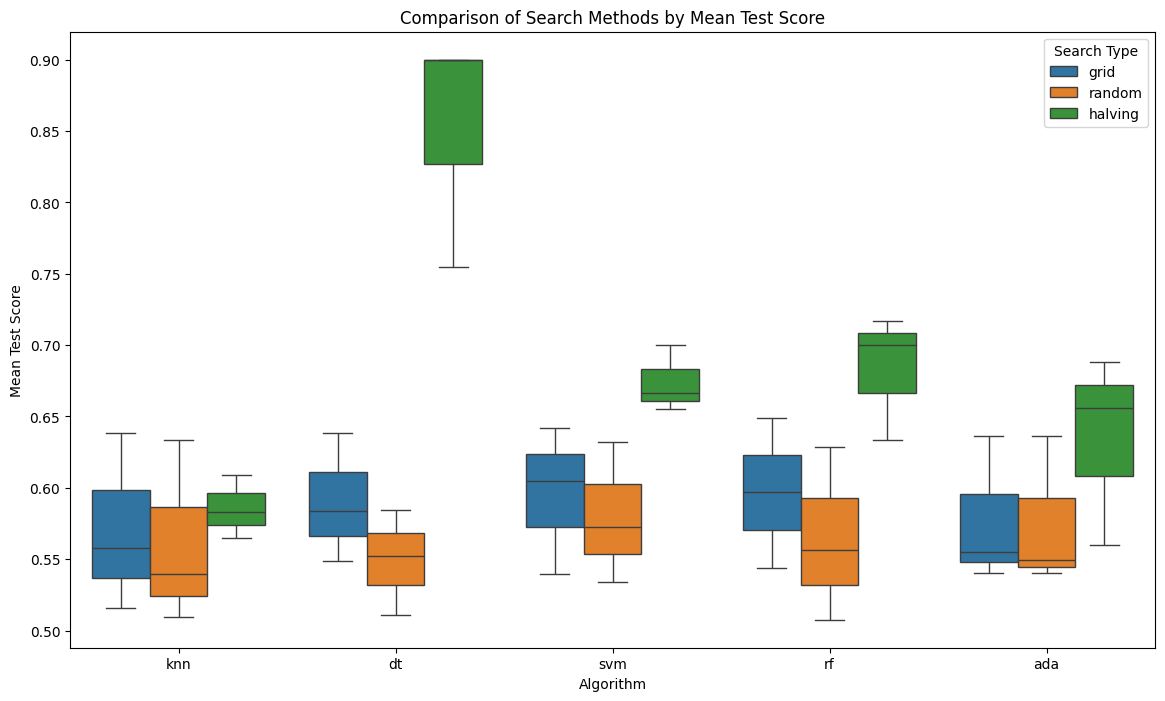

In [85]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=compare_search, x='algorithm', y='mean_test_score', hue='type')
plt.title('Comparison of Search Methods by Mean Test Score')
plt.xlabel('Algorithm')
plt.ylabel('Mean Test Score')
plt.legend(title='Search Type')
plt.show()

In [83]:
compare_search[compare_search["dataset"] == "clinical"]

,dataset,type,time,algorithm,mean_test_score,std_test_score,params
0,clinical,grid,36.868576,knn,0.638715,0.024175,"{'algorithm': 'auto', 'leaf_size': np.int64(10..."
1,clinical,random,0.354413,knn,0.633616,0.033838,"{'weights': 'uniform', 'p': np.int64(5), 'n_ne..."
2,clinical,halving,5.335104,knn,0.608827,0.040188,"{'algorithm': 'brute', 'leaf_size': np.int64(1..."
9,clinical,grid,4.215403,dt,0.638676,0.045179,"{'ccp_alpha': np.float64(0.0), 'criterion': 'e..."
10,clinical,random,0.097470,dt,0.584617,0.044018,"{'splitter': 'best', 'min_samples_split': np.i..."
11,clinical,halving,6.644665,dt,0.754545,0.033402,"{'ccp_alpha': np.float64(0.0), 'criterion': 'l..."
18,clinical,grid,5023.989629,svm,0.642090,0.032930,"{'C': np.float64(0.1), 'coef0': np.float64(0.0..."
19,clinical,random,2.361837,svm,0.631935,0.059902,"{'tol': np.float64(0.007525000000000001), 'shr..."
20,clinical,halving,67.168714,svm,0.654921,0.060297,"{'C': np.float64(2.575), 'coef0': np.float64(5..."
27,clinical,grid,165.438154,rf,0.648866,0.032302,"{'ccp_alpha': np.float64(0.0), 'class_weight':..."


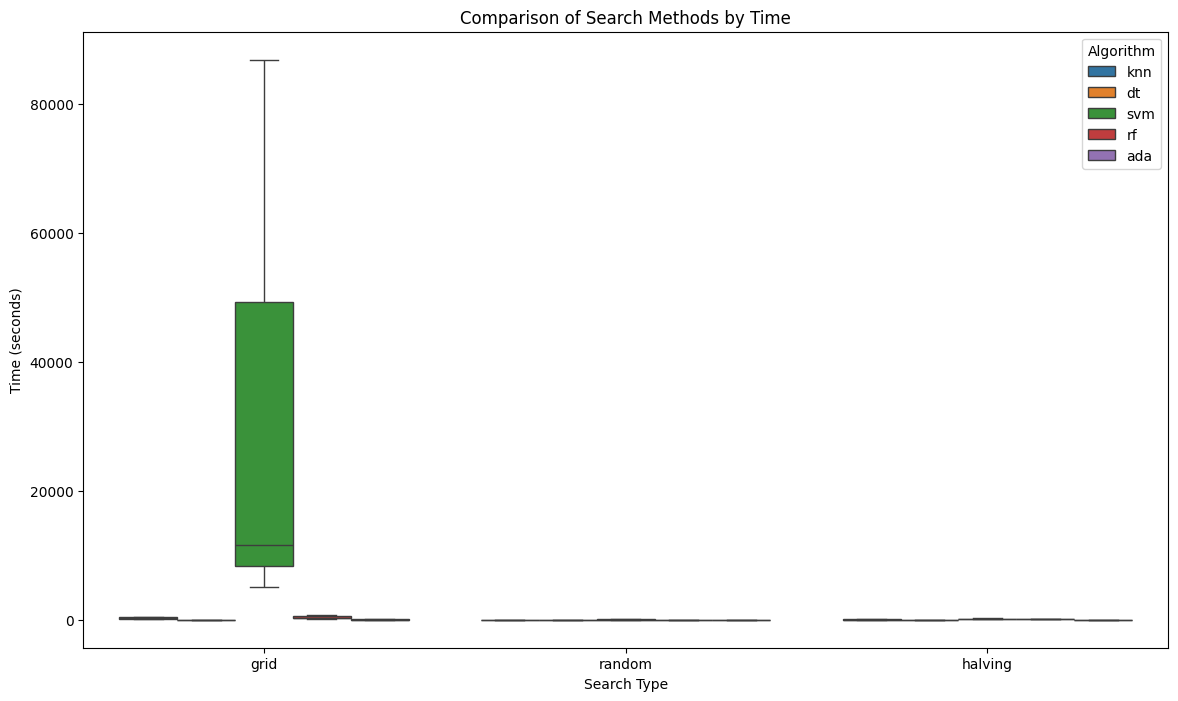

In [84]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=compare_search, x='type', y='time', hue='algorithm')
plt.title('Comparison of Search Methods by Time')
plt.xlabel('Search Type')
plt.ylabel('Time (seconds)')
plt.legend(title='Algorithm')
plt.show()

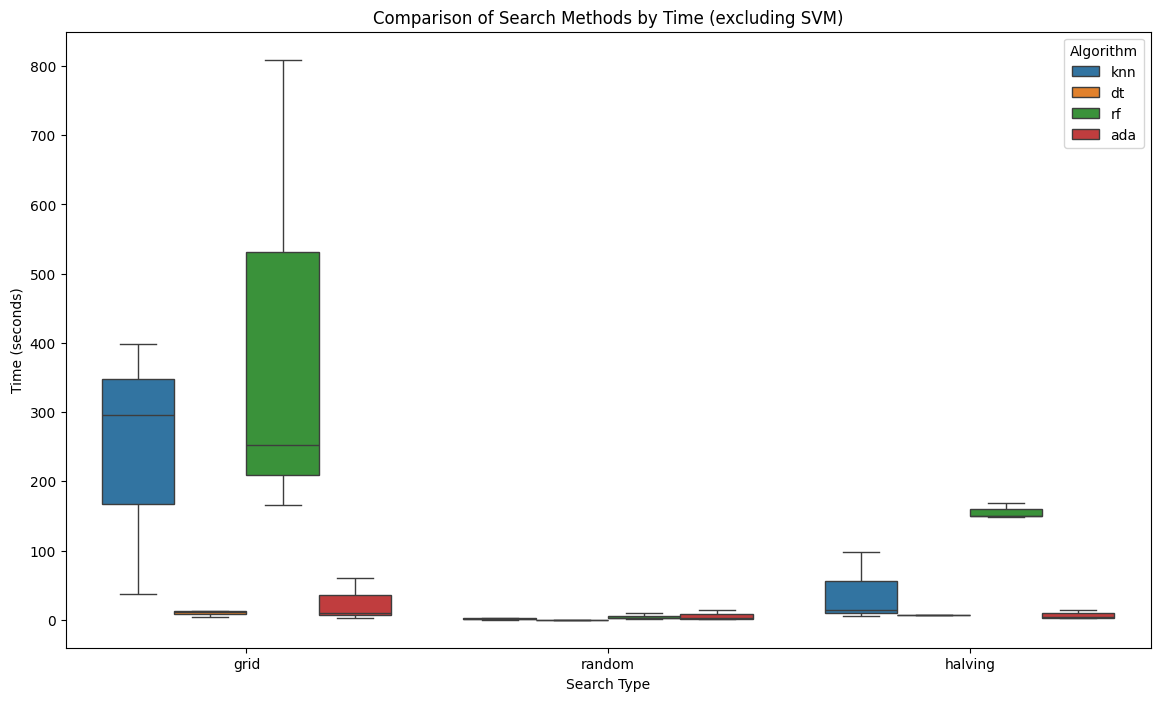

In [67]:
# Filter out SVM from the compare_search DataFrame
filtered_compare_search = compare_search[compare_search['algorithm'] != 'svm']

# Create a boxplot of time by search type
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_compare_search, x='type', y='time', hue='algorithm')
plt.title('Comparison of Search Methods by Time (excluding SVM)')
plt.xlabel('Search Type')
plt.ylabel('Time (seconds)')
plt.legend(title='Algorithm')
plt.show()

# HalvingSearch

In [106]:
models_instance = Models(linspace_size=10, n_iter_search=50)
results = pd.DataFrame(columns=["dataset", "algorithm", "rank", "mean_test_score", "std_test_score", "params"])

for algorithm in models_instance.algorithms.keys():
    for name, data in datasets:
            print(f"Running {algorithm} on {name} dataset")
            
            halving_search = models_instance.halving_search_f1(algorithm)
            halving_search.fit(data, np.squeeze(y))

            result = models_instance.report(halving_search.cv_results_)
            result.insert(0, "dataset", name)
            result.insert(1, "algorithm", algorithm)
            result.insert(2, "best_params", halving_search.best_params_)
            result.insert(3, "best_score", halving_search.best_score_)

            results = pd.concat([results, result])
            

results.to_csv("step_07/halving_search_results_f1.csv", index=False)

Running knn on clinical dataset


NameError: name 'make_scorer' is not defined

### Testings

In [93]:
halving_search_results = pd.read_csv('step_07/halving_search_results.csv')
halving_search_results

,dataset,algorithm,rank,mean_test_score,std_test_score,params
639,mutation,dt,1,0.950000,0.100000,"{'ccp_alpha': np.float64(0.05), 'criterion': '..."
638,mutation,dt,1,0.950000,0.100000,"{'ccp_alpha': np.float64(0.0), 'criterion': 'e..."
640,mutation,dt,3,0.900000,0.200000,"{'ccp_alpha': np.float64(0.1), 'criterion': 'l..."
887,clinical,svm,1,0.833333,0.210819,"{'C': np.float64(1.2000000000000002), 'coef0':..."
886,clinical,svm,1,0.833333,0.210819,"{'C': np.float64(1.2000000000000002), 'coef0':..."
885,clinical,svm,1,0.833333,0.210819,"{'C': np.float64(1.2000000000000002), 'coef0':..."


In [103]:
halving_search_results[(halving_search_results["dataset"] == "mutation")].sort_values(by="std_test_score")

,dataset,algorithm,rank,mean_test_score,std_test_score,params
638,mutation,dt,1,0.950000,0.100000,"{'ccp_alpha': np.float64(0.0), 'criterion': 'e..."
639,mutation,dt,1,0.950000,0.100000,"{'ccp_alpha': np.float64(0.05), 'criterion': '..."
602,mutation,knn,1,0.615152,0.102919,"{'algorithm': 'brute', 'leaf_size': np.int64(7..."
600,mutation,knn,1,0.615152,0.102919,"{'algorithm': 'brute', 'leaf_size': np.int64(7..."
604,mutation,knn,1,0.615152,0.102919,"{'algorithm': 'ball_tree', 'leaf_size': np.int..."
...,...,...,...,...,...,...
2514,mutation,svm,1,0.750000,0.247207,"{'C': np.float64(4.5), 'coef0': np.float64(1.1..."
2519,mutation,svm,1,0.750000,0.247207,"{'C': np.float64(4.5), 'coef0': np.float64(1.1..."
2520,mutation,svm,1,0.750000,0.247207,"{'C': np.float64(4.5), 'coef0': np.float64(1.1..."
2544,mutation,ada,3,0.716667,0.266667,"{'algorithm': 'SAMME.R', 'learning_rate': np.f..."


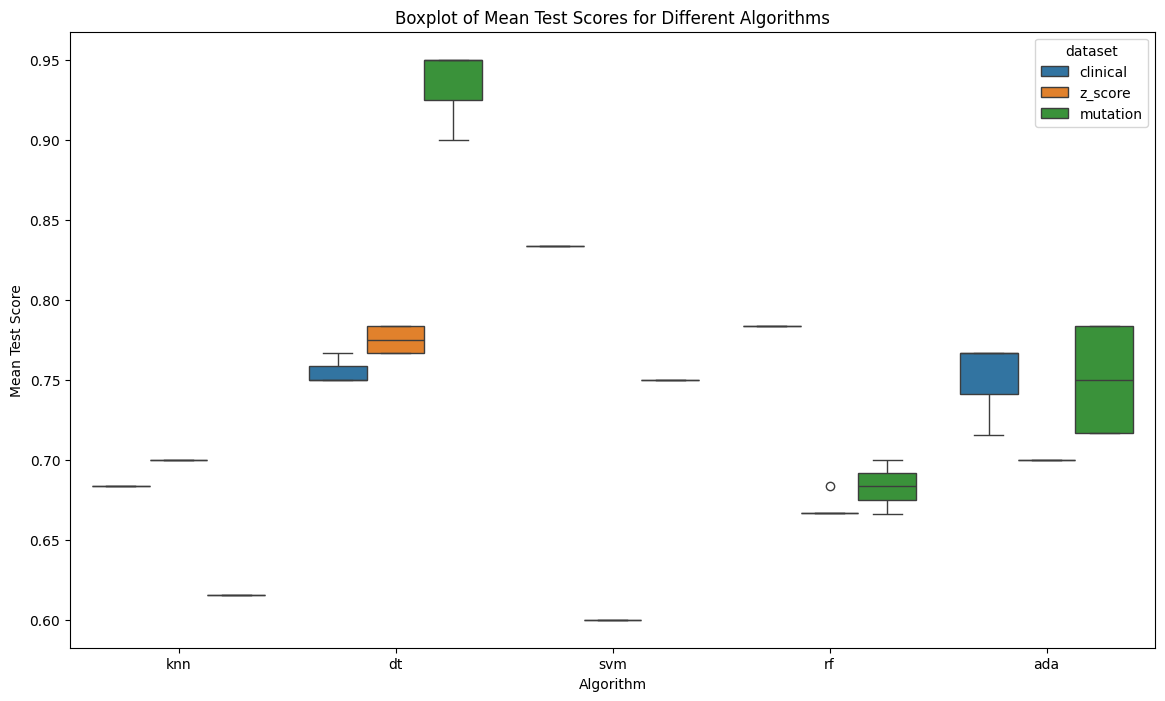

In [87]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=halving_search_results, x='algorithm', y='mean_test_score', hue='dataset')
plt.title('Boxplot of Mean Test Scores for Different Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Mean Test Score')
plt.show()

In [104]:
tmp = []
for dataset in halving_search_results["dataset"].unique():
    best_score = halving_search_results[halving_search_results["dataset"] == dataset].sort_values(by="std_test_score", ascending=False).head(1)
    print(best_score["dataset"].values, best_score["algorithm"].values, best_score["params"].values)

['clinical'] ['rf'] ["{'ccp_alpha': np.float64(0.08888888888888889), 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': np.int64(1), 'max_features': 'log2', 'n_estimators': np.int64(122)}"]
['z_score'] ['rf'] ["{'ccp_alpha': np.float64(0.1), 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': np.int64(78), 'max_features': 'log2', 'n_estimators': np.int64(177)}"]
['mutation'] ['rf'] ["{'ccp_alpha': np.float64(0.1), 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': np.int64(1), 'max_features': 'log2', 'n_estimators': np.int64(166)}"]


In [74]:
clinical_best = halving_search_results[halving_search_results["dataset"] == "clinical"].sort_values(by="mean_test_score", ascending=False).sort_values(by="std_test_score").head(1)
clinical_best

,dataset,algorithm,rank,mean_test_score,std_test_score,params
8,clinical,knn,1,0.683333,0.074289,"{'algorithm': 'brute', 'leaf_size': np.int64(1..."


In [76]:
mutation_best = halving_search_results[halving_search_results["dataset"] == "mutation"].sort_values(by="mean_test_score", ascending=False).sort_values(by="std_test_score").head(1)
mutation_best["params"].values

array(["{'ccp_alpha': np.float64(0.05), 'criterion': 'log_loss', 'max_depth': np.int64(67), 'max_features': 'log2', 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(12), 'splitter': 'best'}"],
      dtype=object)

In [78]:
z_score_best = halving_search_results[halving_search_results["dataset"] == "z_score"].sort_values(by="mean_test_score", ascending=False).sort_values(by="std_test_score").head(1)
z_score_best["params"].values

array(["{'algorithm': 'SAMME', 'learning_rate': np.float64(0.7000000000000001), 'n_estimators': np.int64(10)}"],
      dtype=object)

In [43]:
for best_params in best_scores['params'].apply(lambda x: eval(x)):
    print(best_params)

{'C': np.float64(10.0), 'coef0': np.float64(2.2222222222222223), 'degree': np.int64(10), 'gamma': 'scale', 'kernel': 'sigmoid', 'probability': True, 'shrinking': True, 'tol': np.float64(0.005600000000000001)}
{'ccp_alpha': np.float64(0.05), 'criterion': 'log_loss', 'max_depth': np.int64(67), 'max_features': 'log2', 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(12), 'splitter': 'best'}
{'ccp_alpha': np.float64(0.0), 'criterion': 'entropy', 'max_depth': np.int64(23), 'max_features': 'log2', 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(12), 'splitter': 'best'}
